<a href="https://colab.research.google.com/github/Meridor6919/BeeClassification/blob/master/BeeClassification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
dataset = tfds.load('bee_dataset', split=['train'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/7490 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/bee_dataset/bee_dataset_300/1.0.0.incompleteOCL641/bee_dataset-train.tfrecord*…

Dataset bee_dataset downloaded and prepared to ~/tensorflow_datasets/bee_dataset/bee_dataset_300/1.0.0. Subsequent calls will reuse this data.


In [ ]:
#Split between training data, validation data, test data
splitSize = (0.0, 0.765, 0.9, 1.0)

Testing precision on red channel only

In [ ]:
array = np.vstack(tfds.as_numpy(dataset[0]))
ranges = list([int(array.shape[0] * x) for x in splitSize])

def getDataset(ranges, idx):
  return ( 
      np.array(list(map(lambda x: x[0][:, :, 0], array[ranges[idx] : ranges[idx+1]]))),
      np.array(list(map(lambda x: x[1]['varroa_output'], array[ranges[idx] : ranges[idx+1]])))
      )

train_images, train_labels = getDataset(ranges, 0)
validation_images, validation_labels = getDataset(ranges, 1)
test_images, test_labels = getDataset(ranges, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [ ]:
test_labels.shape

(749,)

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes= 4):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(39168, 32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16, num_classes)
        self.flat = nn.Flatten()
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = self.flat(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
model = Net(2)
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=39168, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

1.0526903867721558
0.542644739151001
0.4265325367450714
0.4465661346912384
0.49228769540786743
0.37080150842666626
0.33334794640541077
0.5412219762802124
0.4953547418117523
0.39134451746940613
0.5588593482971191
0.48284411430358887
0.590161144733429
0.6018064618110657
0.39540594816207886
0.4334337115287781
0.5464088320732117
0.38499927520751953
0.5474844574928284
0.22060027718544006


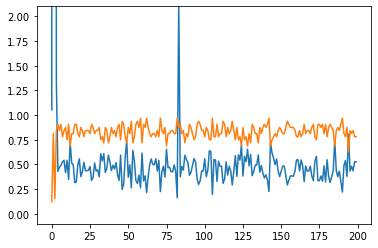

In [ ]:
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.01)

BS = 32
losses, accuracies = [], []
for i in (range(200)):
  samp = np.random.randint(0, train_images.shape[0], size=(BS))
  X = torch.tensor(train_images[samp].reshape((BS,1,300, 150))).float()
  Y = torch.tensor(train_labels[samp]).long()
  model.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  if i % 10 == 0:
    print(loss.item())
  loss = loss.mean()
  loss.backward()
  optim.step()
  optim.zero_grad()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
plt.ylim(-0.1, 2.1)
plt.plot(losses)
plt.plot(accuracies)

In [ ]:
Y_test_preds = torch.argmax(model(torch.tensor(test_images.reshape((749,1, 300, 150))).float()), dim=1).numpy()
(test_labels == Y_test_preds).mean()

0.8251001335113485

In [ ]:
test_labels.shape

(749,)